<a href="https://colab.research.google.com/github/lmcanavals/machine_learning/blob/main/1101_generative_adversarial_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
import numpy as np

In [2]:
X, y = load_digits(return_X_y=True)
X = X.copy().astype("float32") / 16.0
y = y.copy().astype("int32")
print(X.shape, y.shape, X.dtype, y.dtype)
print(X[0])

(1797, 64) (1797,) float32 int32
[0.     0.     0.3125 0.8125 0.5625 0.0625 0.     0.     0.     0.
 0.8125 0.9375 0.625  0.9375 0.3125 0.     0.     0.1875 0.9375 0.125
 0.     0.6875 0.5    0.     0.     0.25   0.75   0.     0.     0.5
 0.5    0.     0.     0.3125 0.5    0.     0.     0.5625 0.5    0.
 0.     0.25   0.6875 0.     0.0625 0.75   0.4375 0.     0.     0.125
 0.875  0.3125 0.625  0.75   0.     0.     0.     0.     0.375  0.8125
 0.625  0.     0.     0.    ]


<ipython-input-3-801af59739e3>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(10, 20, i+1)


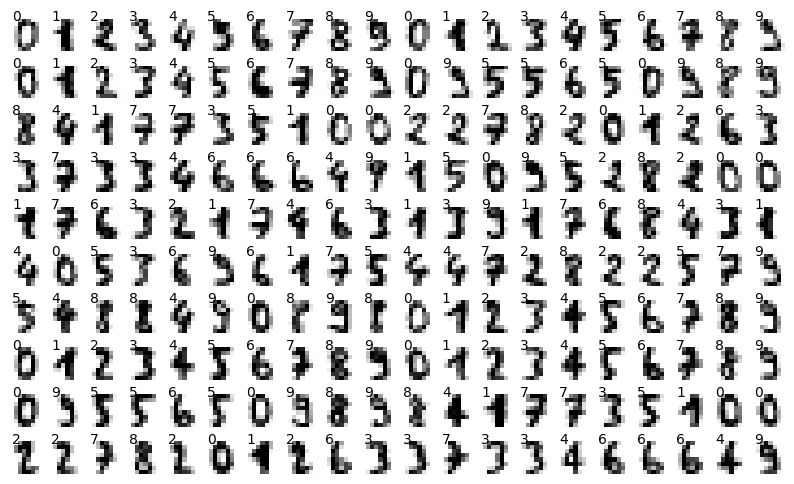

In [3]:
plt.subplots(figsize=(10, 6))
labels = ["zero", "one", "two", "three", "four",
          "five", "six", "seven", "eight", "nine"]
for i in range(200):
    ax = plt.subplot(10, 20, i+1)
    ax.axis('off')
    ax.imshow(X[i].reshape((8, 8)), cmap='gray_r')
    ax.text(0, 0, y[i])
plt.show()

In [4]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torch.nn.modules.activation import LeakyReLU

torch.manual_seed(42)

### Important

as an example we create a data loader using pytorch mnist dataset, wi won't use it and will use instead a 8x8 smaller dataset in hope of shorter training times for the example

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


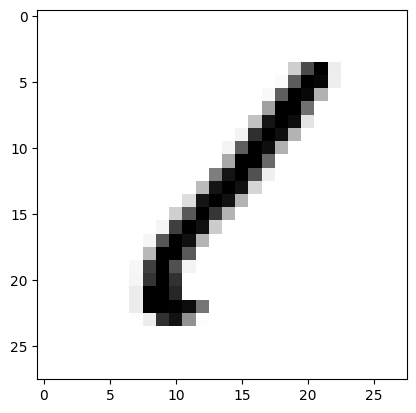

Label: 1


In [5]:
from torchvision.datasets import MNIST

n = 28

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),
                        batch_size=64, shuffle=True)
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray_r')
plt.show()
print(f"Label: {label}")

## Custom Dataset class

A custom Dataset class is needed to load data into a pytorch data loader

In [27]:
class CustomDigitsDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X.reshape((X.shape[0], 8, 8)).copy()
        self.y = y.copy()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img = self.X[idx]
        label = self.y[idx]
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, label

In [28]:
n = 8
dataloader = DataLoader(
    CustomDigitsDataset(X, y, transform=transforms.ToTensor()),
    batch_size=64, shuffle=True)
train_features, train_labels = next(iter(dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([64, 1, 8, 8])
Labels batch shape: torch.Size([64])


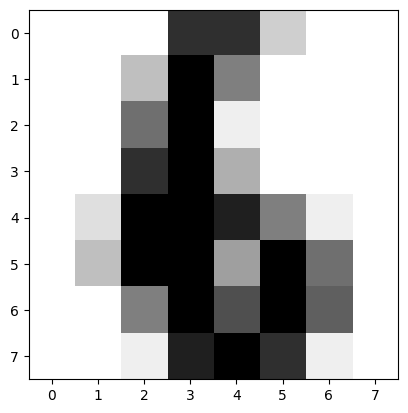

Label: 6


In [29]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray_r')
plt.show()
print(f"Label: {label}")

## View a grid of 5x5 digits

In [30]:
def show_tensor_image(image_tensor, num_images=25, size=(1, n, n)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

## The Generator

### Generator block

In [31]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

### Class Generator

In [32]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=n*n, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim*2),
            get_generator_block(hidden_dim*2, hidden_dim*4),
            get_generator_block(hidden_dim*4, hidden_dim*8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

    def get_gen(self):
        return self.gen

In [33]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

## The Discriminator

In [34]:
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)
    )

In [35]:
class Discriminator(nn.Module):
    def __init__(self, im_dim=n*n, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim*4),
            get_discriminator_block(hidden_dim*4, hidden_dim*2),
            get_discriminator_block(hidden_dim*2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        return self.disc(image)

    def get_disc(self):
        return self.disc

## Training

In [42]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
device = 'cuda'

In [43]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [44]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    return disc_loss

In [45]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    fake_noise = get_noise(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

In [46]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True
gen_loss = False
error = False

In [ ]:
old_generator_weights = None
for epoch in range(n_epochs):
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.view(cur_batch_size, -1).to(device)
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Failure runtime stuff")

        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Epoch {epoch:3} Step {cur_step:4} Generator Loss: {mean_generator_loss} Discriminator Loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_image(fake)
            show_tensor_image(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0

        cur_step += 1

## Conclussion

### Fake images

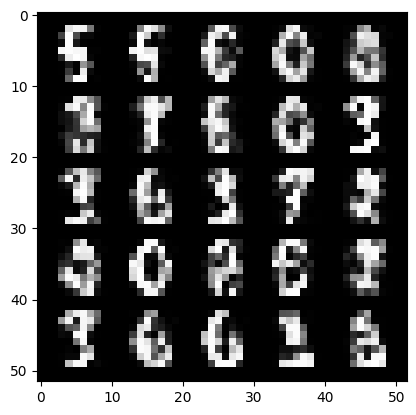

In [52]:
noise = get_noise(25, z_dim, device)
fake = gen(noise)
show_tensor_image(fake)

In [53]:
disc(fake)

tensor([[ 0.9390],
        [ 0.3692],
        [-0.9126],
        [-0.7464],
        [-0.3570],
        [-0.2078],
        [ 0.0601],
        [-0.6439],
        [-0.9034],
        [-0.1356],
        [-0.5760],
        [ 0.0210],
        [-0.3723],
        [ 0.4737],
        [-0.5999],
        [-0.3554],
        [-0.3610],
        [-0.2484],
        [-0.6178],
        [-0.4514],
        [-0.1884],
        [ 0.2737],
        [-0.0474],
        [ 0.1004],
        [ 0.2193]], device='cuda:0', grad_fn=<AddmmBackward0>)

### Real ones

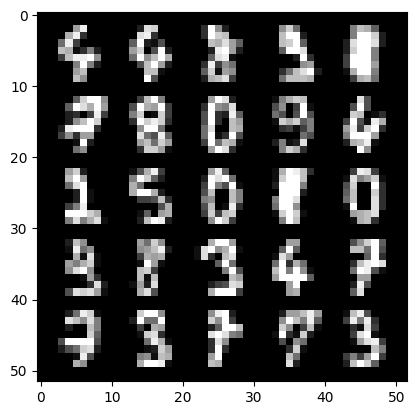

In [51]:
for real, _ in dataloader:
    show_tensor_image(real)
    break